<a href="https://colab.research.google.com/github/zqiu0/COVID-19-Analysis/blob/master/COVID19_Analysis_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note:* this notebook contains all code written for this project.

### Libraries and Setup

In [ ]:
! sudo apt install openjdk-8-jdk
! sudo update-alternatives --config java

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxxf86dga1 openjdk-8-jre x11-utils
Suggested packages:
  openjdk-8-demo openjdk-8-source visualvm icedtea-8-plugin mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxxf86dga1 openjdk-8-jdk openjdk-8-jre x11-utils
0 upgraded, 8 newly installed, 0 to remove and 25 not upgraded.
Need to get 4,942 kB of archives.
After this operation, 13.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 fonts-dejavu-core all 2.37-1 [1,041 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 fonts-dejavu-extra all 2.37-1 [1,953 kB

In [ ]:
%%capture
!pip install pandasql

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import pandasql as ps

# US Data Visualization
In this section we will be looking at US COVID-19 data and look for interesting patterns in the data between different states. The data we're using will include all cases up to April 29.


## Data loading and processing
Since there are two sources of COVID data, one from the New York times and one from John Hopkins, we will merge the data into one dataframe. Note that the original combined dataframe of US data provided on Github does not include all counties since some counties are only available in one datasource.
The John Hopkins data starts on 2020-03-22, which is day 61 since the first day of data collection (2020-01-21), so we will add 61 to all days from JHU data to make it consistent.

In [ ]:
us_jhu_df = pd.read_csv("/content/drive/My Drive/COVID19/df_us_jhu.csv", header=0)
us_jhu_df['day'] = us_jhu_df['day'] + 61
us_nyt_df = pd.read_csv("/content/drive/My Drive/COVID19/df_us_nyt.csv", header=0)

In [ ]:
df_list = list()
nyt_only_df = ps.sqldf("SELECT * FROM us_nyt_df WHERE date < '2020-03-22'")
nyt_only_df.rename(columns={'cases': 'cases_nyt', 'deaths':'deaths_nyt'}, inplace=True)
nyt_only_df['cases_jhu'] = np.nan
nyt_only_df['deaths_jhu'] = np.nan
nyt_only_df['recovered'] = np.nan
nyt_only_df['active'] = np.nan
df_list.append(nyt_only_df)

In [ ]:
# Projecting NYT data we're interested in to smaller dataframe for merging
nyt_df_small = us_nyt_df[['date', 'fips', 'cases', 'deaths']]
nyt_df_small = nyt_df_small[nyt_df_small['date'] >= '2020-03-22']
nyt_df_small.rename(columns={'cases': 'cases_nyt', 'deaths': 'deaths_nyt'}, inplace=True)

In [ ]:
jhu_nyt_df = ps.sqldf("""SELECT j.*, n.cases_nyt, n.deaths_nyt FROM us_jhu_df j LEFT JOIN nyt_df_small n 
                    ON j.date = n.date AND j.fips = n.fips""")

jhu_nyt_df.rename(columns={'cases': 'cases_jhu', 'deaths': 'deaths_jhu'}, inplace=True)
df_list.append(jhu_nyt_df)

In [ ]:
us_combined_df = pd.concat(df_list)

After merging the dataframe, we have two columns for cases and deaths, one from NYT and the other from JHU. We will take the average of the two data and store it in the 'cases' and 'deaths' columns. We will also replace missing data with 0's.

In [ ]:
#cleaning
us_combined_df['cases'] = us_combined_df[['cases_nyt', 'cases_jhu']].mean(axis=1)
us_combined_df['deaths'] = us_combined_df[['deaths_nyt', 'deaths_jhu']].mean(axis=1)
us_clean_df = us_combined_df.drop(labels=['cases_nyt', 'deaths_nyt', 'cases_jhu', 'deaths_jhu', 'fips'], axis=1)
us_clean_df.fillna(0, inplace=True)

## Data visualization
Using the us_clean_df created above, we will make various plots to observe trends and patterns.

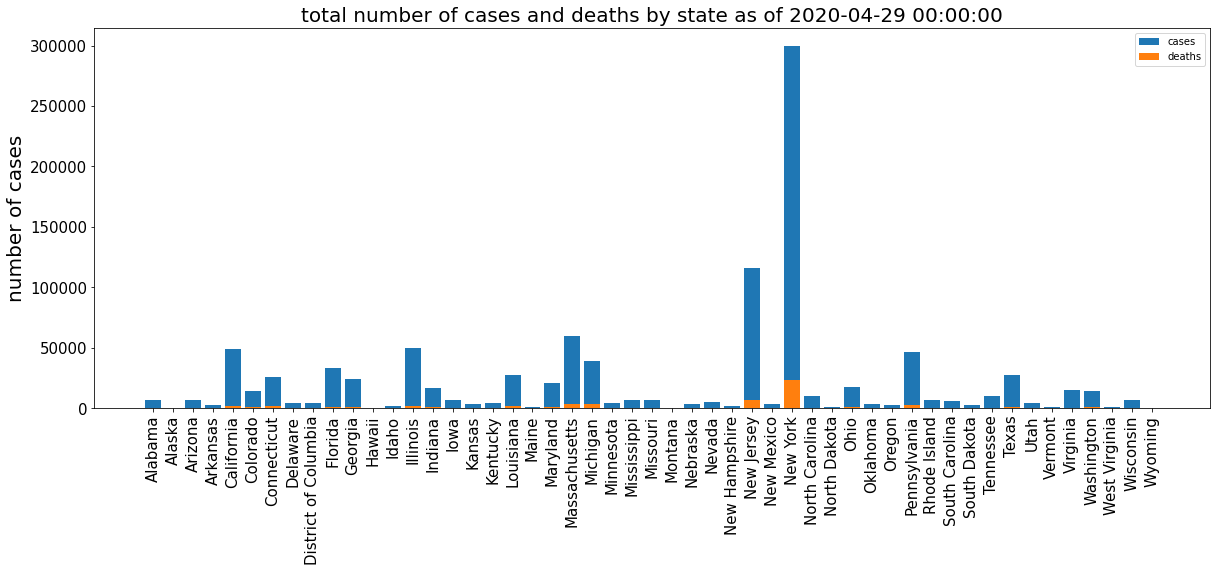

In [ ]:
from datetime import timedelta

most_recent_day = us_clean_df['day'].max()
query = """SELECT state, SUM(cases) AS cases FROM us_clean_df 
          WHERE day = '{}' GROUP BY state""".format(most_recent_day)
us_cases_by_state_df = ps.sqldf(query)

deaths_query = """SELECT state, SUM(deaths) AS deaths FROM us_clean_df 
          WHERE day = '{}' GROUP BY state""".format(most_recent_day)
us_deaths_by_state_df = ps.sqldf(deaths_query)

# plot
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
plt.rc('axes', titlesize=20, labelsize=20) 
plt.figure(figsize=(20, 7))
plt.bar(us_cases_by_state_df['state'], us_cases_by_state_df['cases'], label='cases')
plt.bar(us_deaths_by_state_df['state'], us_deaths_by_state_df['deaths'], label='deaths')
plt.xticks(rotation=90)

recent_date = pd.to_datetime('2020-01-21') + timedelta(most_recent_day)
plt.title("total number of cases and deaths by state as of {}".format(recent_date))
plt.ylabel("number of cases")
plt.legend()
plt.show()

We can see that states in the Northeast with major cities have significantly more cases than other states. Also, in states like Washington and California where COVID first started, number of cases are comparably less than the northeast states.

To be more comprehensive, we will look at the death rate of each state. The red horizontal line indicates the death rate of New York.

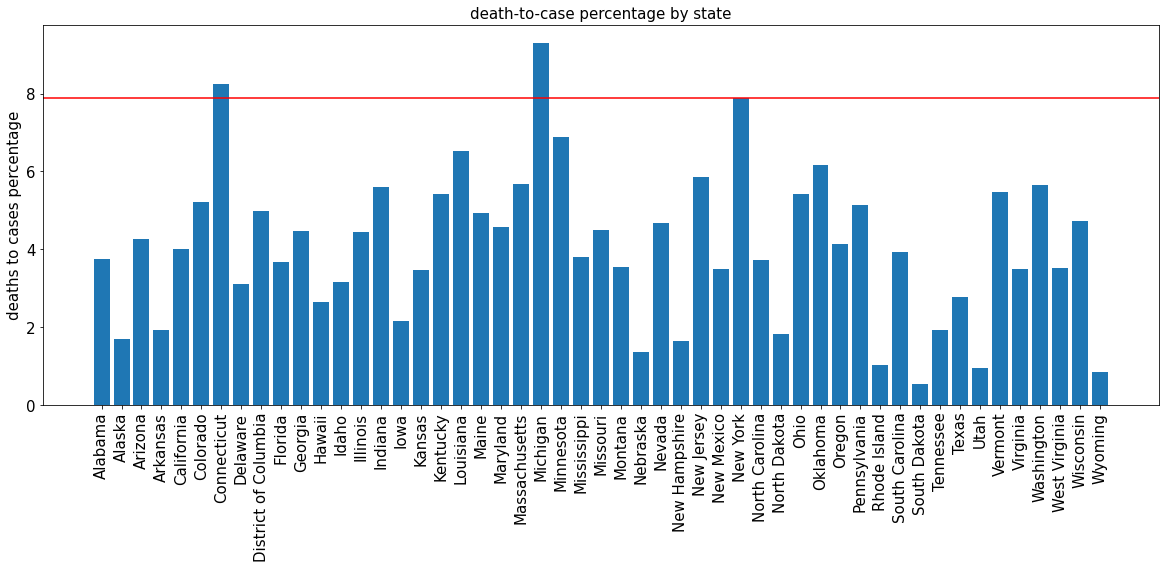

In [ ]:
us_cases_deaths_combined = us_cases_by_state_df.merge(us_deaths_by_state_df, on='state')
us_cases_deaths_combined['death to case'] = us_cases_deaths_combined['deaths'] / us_cases_deaths_combined['cases'] * 100
us_cases_deaths_combined.sort_values(by='state', inplace=True)

ny_death_rate = us_cases_deaths_combined[us_cases_deaths_combined['state'] == 'New York'] \
                .reset_index(drop=True).loc[0, 'death to case']
plt.figure(figsize=(20, 7))
plt.axhline(y=ny_death_rate, color='r', linestyle='-')
plt.bar(us_cases_deaths_combined['state'], us_cases_deaths_combined['death to case'])
plt.xticks(rotation=90)
plt.title('death-to-case percentage by state')
plt.ylabel('deaths to cases percentage')
plt.show()

Different from expected, some states with less number of cases have a higher death rate. It seems that even though Connecticut has a far smaller number of confirmed cases, its death rate is much higher than states like Georgia and Indiana where they have a similar number of cases. Out of all states, Michigan has the highest death rate, and South Dakota the lowest.

Next, we will rank each states by the number of confirmed cases and death rate, and find the average ranking so we can determine which states are doing the best right now. The states will be ranked in descending order, so that states with larger number of cases and higher death rates are ranked higher.

In [ ]:
us_cases_deaths_combined.sort_values(by='death to case', inplace=True, ascending=False,ignore_index=True)
us_cases_deaths_combined['percent ranking'] = us_cases_deaths_combined.index
us_cases_by_state_df.sort_values(by='cases', inplace=True, ascending=False, ignore_index=True)
us_cases_by_state_df['case ranking'] = us_cases_by_state_df.index

us_ranking = us_cases_deaths_combined.merge(us_cases_by_state_df, on='state')
us_ranking['average ranking'] = (us_ranking['percent ranking'] + us_ranking['case ranking']) / 2
us_ranking = us_ranking[['state', 'average ranking']]
us_ranking.sort_values(by='average ranking', inplace=True, ascending=False, ignore_index=True)
us_ranking.head(5)

,state,average ranking
0,Wyoming,48.5
1,Alaska,47.0
2,South Dakota,45.0
3,North Dakota,44.0
4,Hawaii,43.0


Wyoming, with an average ranking of 48.5 in its number of cases and death rate, is the best place to be during the pandemic in the US. The top 5 best states to be are all in the West or Midwest.

We will now look at the top 5 states with the most number of cases. We will plot the number of cases in each of these states by day, starting on the day of first diagnosed case in the 5 states.

In [ ]:
first = us_cases_by_state_df.loc[0, 'state']
second = us_cases_by_state_df.loc[1, 'state']
third = us_cases_by_state_df.loc[2, 'state']
forth = us_cases_by_state_df.loc[3, 'state']
fifth = us_cases_by_state_df.loc[4, 'state']

In [ ]:
query1 = """SELECT day, state, SUM(cases) AS cases_by_day FROM us_clean_df 
                          WHERE state == '{}' GROUP BY day """.format(first)
first_df = ps.sqldf(query1)

query2 = """SELECT day, state, SUM(cases) AS cases_by_day FROM us_clean_df 
                          WHERE state == '{}' GROUP BY day """.format(second)
second_df = ps.sqldf(query2)

query3 = """SELECT day, state, SUM(cases) AS cases_by_day FROM us_clean_df 
                          WHERE state == '{}' GROUP BY day """.format(third)
third_df = ps.sqldf(query3)

query4 = """SELECT day, state, SUM(cases) AS cases_by_day FROM us_clean_df 
                          WHERE state == '{}' GROUP BY day """.format(forth)
forth_df = ps.sqldf(query4)

query5 = """SELECT day, state, SUM(cases) AS cases_by_day FROM us_clean_df 
                          WHERE state == '{}' GROUP BY day """.format(fifth)
fifth_df = ps.sqldf(query5)

In [ ]:
first_day = min(first_df['day'].min(), second_df['day'].min(), 
                third_df['day'].min(), forth_df['day'].min(),
                fifth_df['day'].min())

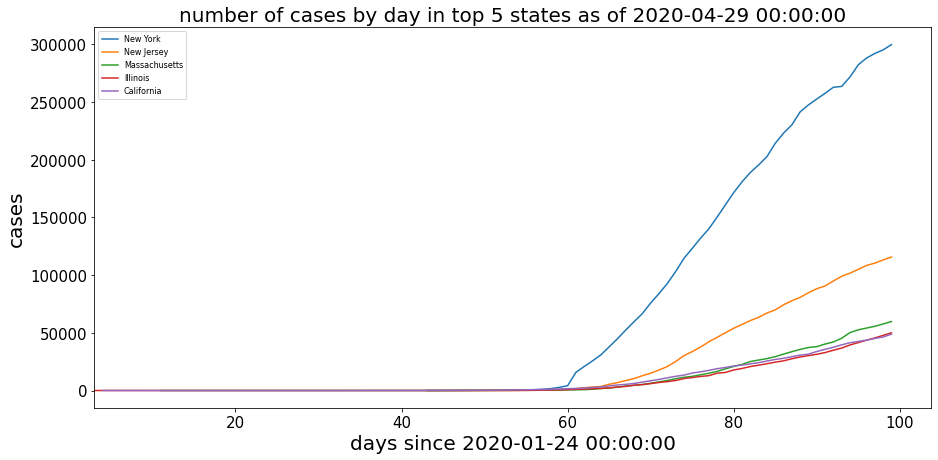

In [ ]:
#plot
plt.figure(figsize=(15, 7))
plt.plot(first_df['day'], first_df['cases_by_day'], label=first_df.loc[0,'state'])
plt.plot(second_df['day'], second_df['cases_by_day'], label=second_df.loc[0, 'state'])
plt.plot(third_df['day'], third_df['cases_by_day'], label=third_df.loc[0, 'state'])
plt.plot(forth_df['day'], forth_df['cases_by_day'], label=forth_df.loc[0, 'state'])
plt.plot(fifth_df['day'], fifth_df['cases_by_day'], label=fifth_df.loc[0, 'state'])
plt.xlim(first_day)

plt.xlabel("days since {}".format(pd.to_datetime('2020-01-21') + timedelta(days=first_day)))
plt.ylabel('cases')
plt.title('number of cases by day in top 5 states as of {}'.format(recent_date))
plt.legend(prop={'size': 8})
plt.show()

Since New York can be basically considered an outlier, the other states appear compressed. The number of cass in New York and New Jersey are very distinguishable, while the other states have a similar number of cases.

Next we'll look at the number of increases in these five states in each day.

In [ ]:
first_df['increase'] = first_df['cases_by_day'].diff()
second_df['increase'] = second_df['cases_by_day'].diff()
third_df['increase'] = third_df['cases_by_day'].diff()
forth_df['increase'] = forth_df['cases_by_day'].diff()
fifth_df['increase'] = fifth_df['cases_by_day'].diff()

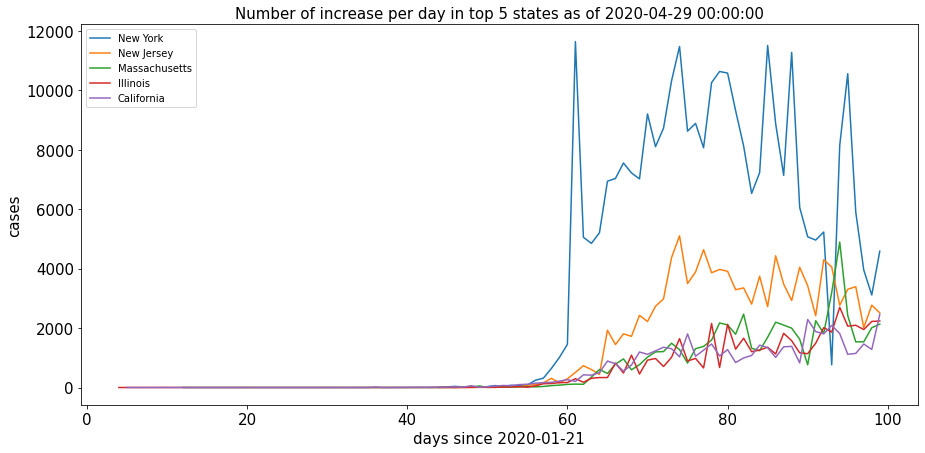

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(first_df['day'], first_df['increase'], label=first_df.loc[0,'state'])
plt.plot(second_df['day'], second_df['increase'], label=second_df.loc[0,'state'])
plt.plot(third_df['day'], third_df['increase'], label=third_df.loc[0,'state'])
plt.plot(forth_df['day'], forth_df['increase'], label=forth_df.loc[0,'state'])
plt.plot(fifth_df['day'], fifth_df['increase'], label=fifth_df.loc[0,'state'])
plt.title("Number of increase per day in top 5 states as of {}".format(recent_date))
plt.xlabel('days since 2020-01-21')
plt.ylabel('cases')
plt.legend()
plt.show()

On day 61, New York had a huge increase in its number of cases. The trends of New York and New Jersey are very similar, which is expected since the two states are neighbors. On day 93, the number of increases in New York is below 1000, this could be caused by adjustmens in the data collected. Otherwise, the number of increases in New York averages around 5000, and around 2000 in New Jersey. The other three states all have averages around 500 cases per day.

Lastly, we can look at the number of cases by regions.

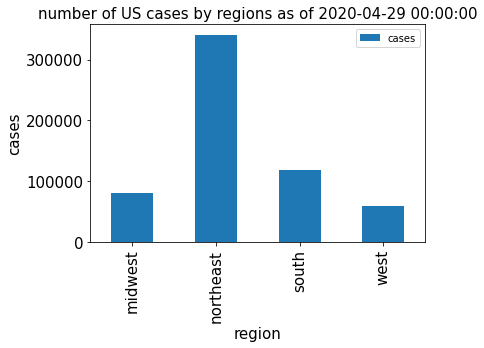

In [ ]:
region_cases_df = ps.sqldf("""SELECT region, SUM(cases) AS cases FROM us_clean_df 
                           WHERE day = 84 GROUP BY region""")

plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
plt.rc('axes', titlesize=15, labelsize=15)
region_cases_df.plot.bar('region', 'cases')
plt.ylabel("cases")
plt.title('number of US cases by regions as of {}'.format(recent_date))
plt.show()

Western states have the lowest number of cases, which is consistent with our observation that western states tend to be safer places to be. It is worth noting that Northeast has a higher number of diagnosed cases than the other three regions combined.

# Global Data

## Data loading and processing

Next, we'll take a look at the global data. The deaths and cases are stored in two separate dataframes, so we'll combine and clean the data.

In [ ]:
world_case_df = pd.read_csv("/content/drive/My Drive/COVID19/df_all_cases.csv", header=0)
world_death_df = pd.read_csv("/content/drive/My Drive/COVID19/df_all_deaths.csv", header=0)

In [ ]:
world_df = world_case_df.join(world_death_df['deaths'])
world_df.drop(labels=['lat', 'long'], inplace=True, axis=1)

## Data Visualization
We'll also visualize the global data. First we can compare the trend of New York and Hubei, where the pandemic began.

In [ ]:
ny_by_day = us_clean_df[us_clean_df['state'] == 'New York']
ny_by_day = ps.sqldf("""SELECT date, day, state, SUM(cases) AS cases, SUM(deaths) 
                        AS deaths FROM ny_by_day GROUP BY state, day """)

In [ ]:
hubei_by_day = world_df[world_df['province_state'] == "Hubei"]

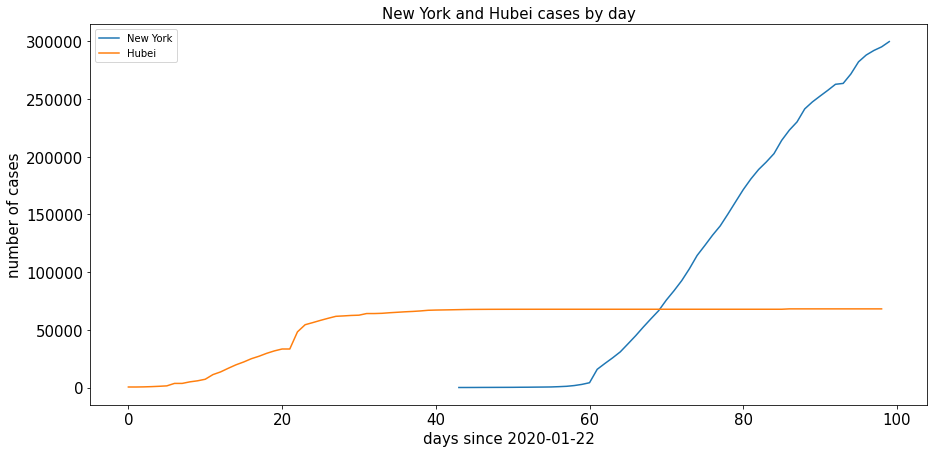

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(ny_by_day['day'], ny_by_day['cases'], label='New York')
plt.plot(hubei_by_day['day'], hubei_by_day['cases'], label='Hubei')
plt.xlabel('days since 2020-01-22')
plt.ylabel('number of cases')
plt.title("New York and Hubei cases by day")
plt.legend()
plt.show()

The situation in Hubei stabilizes after around 20 days, but cases are still steadily increasing in New York.
Next we'll look at the number of deaths.

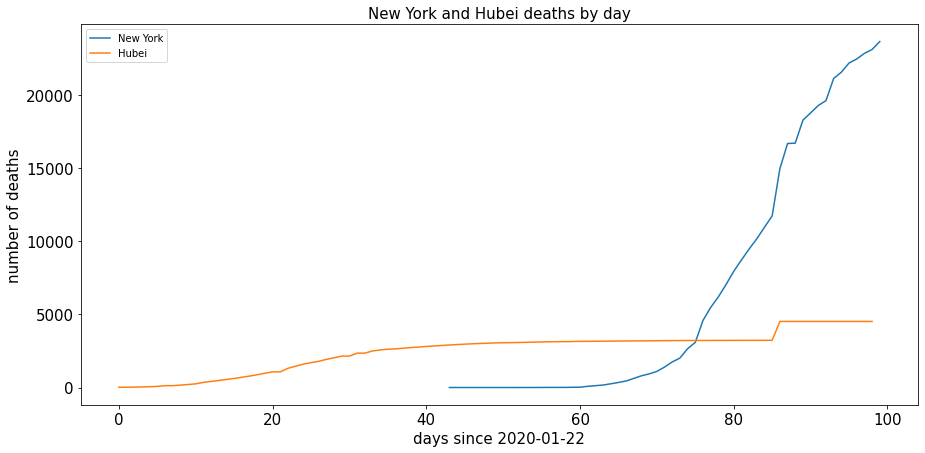

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(ny_by_day['day'], ny_by_day['deaths'], label='New York')
plt.plot(hubei_by_day['day'], hubei_by_day['deaths'], label='Hubei')
plt.xlabel('days since 2020-01-22')
plt.ylabel('number of deaths')
plt.title("New York and Hubei deaths by day")
plt.legend()
plt.show()

The trend of death tolls are also similar to that of the cases. Hubei has a much steadier trend that stabilizies after 40 days, and the death toll in New York is still increasing.

Next we'll analyze the cases trend in the US, China, Italy, UK, and Korea, where the pandemic became emergencies quickly.

In [ ]:
us_by_day = world_df[world_df['country'] == 'US']
china_by_day = ps.sqldf("""SELECT date, day, SUM(cases) AS cases, SUM(deaths) AS deaths 
                        FROM world_df WHERE country == 'China' GROUP BY country, day """)
italy_by_day = world_df[world_df['country'] == 'Italy']
korea_by_day = world_df[world_df['country'] == 'Korea, South']
uk_by_day = ps.sqldf("""SELECT date, day, SUM(cases) AS cases, SUM(deaths) AS deaths 
                        FROM world_df WHERE country == 'United Kingdom' GROUP BY country, day """)

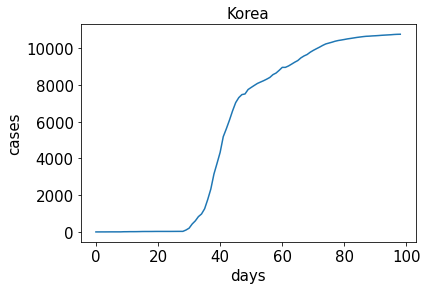

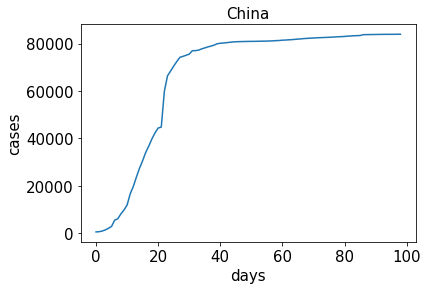

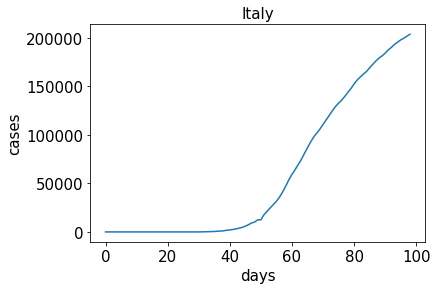

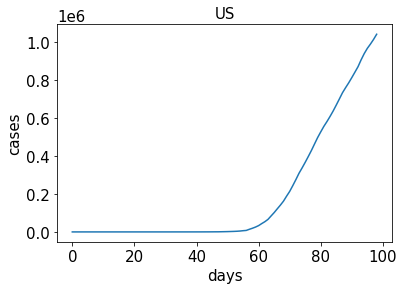

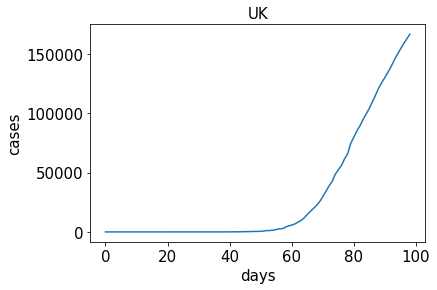

In [ ]:
plt.plot(korea_by_day['day'], korea_by_day['cases'])
plt.title('Korea')
plt.xlabel('days')
plt.ylabel('cases')
plt.show()

plt.plot(china_by_day['day'], china_by_day['cases'])
plt.title('China')
plt.xlabel('days')
plt.ylabel('cases')
plt.show()

plt.plot(italy_by_day['day'], italy_by_day['cases'])
plt.title('Italy')
plt.xlabel('days')
plt.ylabel('cases')
plt.show()

plt.plot(us_by_day['day'], us_by_day['cases'])
plt.title('US')
plt.xlabel('days')
plt.ylabel('cases')
plt.show()

plt.plot(uk_by_day['day'], uk_by_day['cases'])
plt.title('UK')
plt.xlabel('days')
plt.ylabel('cases')
plt.show()

It is interesting that Korea and China share similar trends, and US, UK, and Italy have almost identical graphs. In countries where either the government imposed strict quarantine rules or there is a strong social atmosphere to practice social distancing, the pandemic seems to be better controlled and stabilizes comparably faster than other countries.

# US Case Prediction

## Preparing Data
Next, we will train a random forest regression model using sklearn in order to predict the number of cases in the US by states for the month of May. Since counties are very small compared to the country, we will work with states only and prepare a new dataframe with cases column as total number of cases in the state. Then we can one hot encode categorical features like state, sub region, and region.

In [ ]:
us_daily_case = ps.sqldf("SELECT day, state, sub_region, region, lat, long, SUM(cases) \
                         AS cases FROM us_clean_df GROUP BY state, day")

In [ ]:
us_d = us_daily_case.copy()
us_d.drop('cases', inplace = True, axis=1) 
us_d.to_csv('us_daily_feature.csv')

In [ ]:
us_daily_case['state'] = us_daily_case['state'].astype('category')
us_daily_case['sub_region'] = us_daily_case['sub_region'].astype('category')
us_daily_case['region'] = us_daily_case['region'].astype('category')
us_daily_case = pd.get_dummies(us_daily_case, columns=['state', 'sub_region', 'region'])

We save the pandas dataframe as a csv file so we can read it as a spark dataframe for the training.

In [ ]:
us_daily_2 = us_daily_case.copy()
us_daily_2.rename(columns = {'cases':'label'}, inplace = True) 
us_daily_2.to_csv('us_daily.csv')

## Random Forest Regression
After visualizing different data, we will now train regression models to predict cases and deaths in the US.

### Spark Library Setup

In [ ]:
!apt install libkrb5-dev
!wget https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
!pip install pyspark --user
!pip install seaborn --user
!pip install plotly --user
!pip install imageio --user
!pip install folium --user

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  comerr-dev krb5-multidev libcom-err2 libgssrpc4 libkadm5clnt-mit11
  libkadm5srv-mit11 libkdb5-9
Suggested packages:
  doc-base krb5-doc krb5-user
The following NEW packages will be installed:
  comerr-dev krb5-multidev libgssrpc4 libkadm5clnt-mit11 libkadm5srv-mit11
  libkdb5-9 libkrb5-dev
The following packages will be upgraded:
  libcom-err2
1 upgraded, 7 newly installed, 0 to remove and 24 not upgraded.
Need to get 358 kB of archives.
After this operation, 1,992 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libcom-err2 amd64 1.44.1-1ubuntu1.3 [8,848 B]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libgssrpc4 amd64 1.16-2ubuntu0.1 [54.2 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libkdb5-9 amd64 1.16-2ubuntu0.1 [37.2 kB]
Get:4 http

In [ ]:
!apt update
!apt install gcc python-dev libkrb5-dev

Get:1 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic/main amd64 Packages [37.4 kB]
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubu

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.appName('ml').getOrCreate()

In [ ]:
%load_ext sparkmagic.magics

In [ ]:
#graph section
import networkx as nx
# SQLite RDBMS
import sqlite3
# Parallel processing
# import swifter
import pandas as pd
# NoSQL DB
from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError, OperationFailure

import os
os.environ['SPARK_HOME'] = '/content/spark-2.4.5-bin-hadoop2.7'
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext

In [ ]:
try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)

### Model Setup
Now we can read the data we prepared as a spark dataframe and set up our training model.

In [ ]:
data_sdf = spark.read.csv('/content/drive/My Drive/COVID19/us_daily.csv' ,inferSchema=True, header=True)

In [ ]:
data_sdf.show(5)

+---+---+-----------+------------+-----+-------------+------------+-------------+--------------+----------------+--------------+-----------------+--------------+--------------------------+-------------+-------------+------------+-----------+--------------+-------------+----------+------------+--------------+---------------+-----------+--------------+-------------------+--------------+---------------+-----------------+--------------+-------------+--------------+------------+-------------------+----------------+----------------+--------------+--------------------+------------------+----------+--------------+------------+------------------+------------------+--------------------+------------------+---------------+-----------+----------+-------------+--------------+----------------+-------------------+---------------+-------------+-----------------------------+-----------------------------+-----------------------+-------------------+----------------------+------------------+---------------

We define our training pipeline with three stages: assembler, PCA, and regression. The features will be all columns other than the index column and cases. The label will be the case column.

In [ ]:
from pyspark.ml.feature import VectorAssembler

all_columns = data_sdf.columns
drop_columns = ['label', '_c0']
columns_to_use = [i for i in all_columns if i not in drop_columns]

assembler = VectorAssembler(inputCols=columns_to_use, outputCol='features')

We will use PCA to reduce the number of dimensions of the dataset before feeding it to our model. First, we'll determine the number of components to reduce to.

In [ ]:
label = data_sdf.select('label').toPandas()
#label = us_daily_2['label']
features = data_sdf.drop('label').toPandas()
#features = us_daily_2.drop(['label'], axis=1)

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(features, \
                                                    label, \
                                                    test_size=0.20)

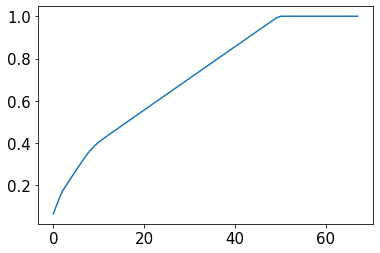

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=len(x_train.columns))
x_train = StandardScaler().fit_transform(x_train)
pca.fit(x_train)

pc_vs_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(pc_vs_variance)

The plot seems to taper off at 50, so we'll keep 50 components in our data. Now we have all stages in our pipeline.


In [ ]:
from pyspark.ml.feature import PCA
pca = PCA(k=50, inputCol='features', outputCol='pca_features')

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol='pca_features', labelCol='label')

In [ ]:
from pyspark.ml import Pipeline

pipe = Pipeline(stages = [assembler, pca, rf])

### Model Training
Now it's time to train our model. We will tune the hyperparameters of the regression model with a grid and evaluate the grid parameters with a three fold cross validation. We'll use a regression evaluatior for evaluating and the predefined pipeline as our estimator. For this model, we will be tuning the number of trees to use and the max depth.

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [5, 10, 15]) \
    .addGrid(rf.maxDepth, [20, 25, 30]) \
    .build()

In [ ]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

crossval = CrossValidator(estimator=pipe,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)

Now we can split our data into train and test sets, and fit our model with the best hyperparameters to the data.

In [ ]:
train_sdf, test_sdf = data_sdf.randomSplit(weights=[0.8, 0.2])

In [ ]:
cvModel = crossval.fit(train_sdf)

In [ ]:
predictions = cvModel.transform(test_sdf)

In [ ]:
predictions.show(15)

+---+---+-----------+-------------------+------+-------------+------------+-------------+--------------+----------------+--------------+-----------------+--------------+--------------------------+-------------+-------------+------------+-----------+--------------+-------------+----------+------------+--------------+---------------+-----------+--------------+-------------------+--------------+---------------+-----------------+--------------+-------------+--------------+------------+-------------------+----------------+----------------+--------------+--------------------+------------------+----------+--------------+------------+------------------+------------------+--------------------+------------------+---------------+-----------+----------+-------------+--------------+----------------+-------------------+---------------+-------------+-----------------------------+-----------------------------+-----------------------+-------------------+----------------------+------------------+-------

We can evaluate the performance of our regression model by looking at the RMSE and the R2 score.

In [ ]:
min_cases = float(data_sdf.select('label').toPandas().min())
max_cases = float(data_sdf.select('label').toPandas().max())
avg_cases = float(data_sdf.select('label').toPandas().mean())

print('min: {0}'.format(min_cases))
print('max: {0}'.format(max_cases))
print('average: {0}'.format(avg_cases))

min: 1.0
max: 299701.0
average: 6406.692448436461


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

re = RegressionEvaluator(labelCol='label', predictionCol='prediction')
rmse = re.evaluate(predictions)

In [ ]:
print('rmse: {0}'.format(rmse))

rmse: 562.0436879897123


In [ ]:
y_true = predictions.select("label").toPandas()
y_pred = predictions.select("prediction").toPandas()

import sklearn.metrics
r2_score = sklearn.metrics.r2_score(y_true, y_pred)
print('r2_score: {0}'.format(r2_score))

r2_score: 0.9993655955851958


Our RMSE seems reasonable compared the other statistics of our data like min, max, and average. The R2 score also signifies good performance since our model accounts for close to 100% of the variance in the data. We can better assess model performance by doing some visualization on prediction results of the test set.

We can take a closer look at which features from the dataset are the most influential on the model's predictions.

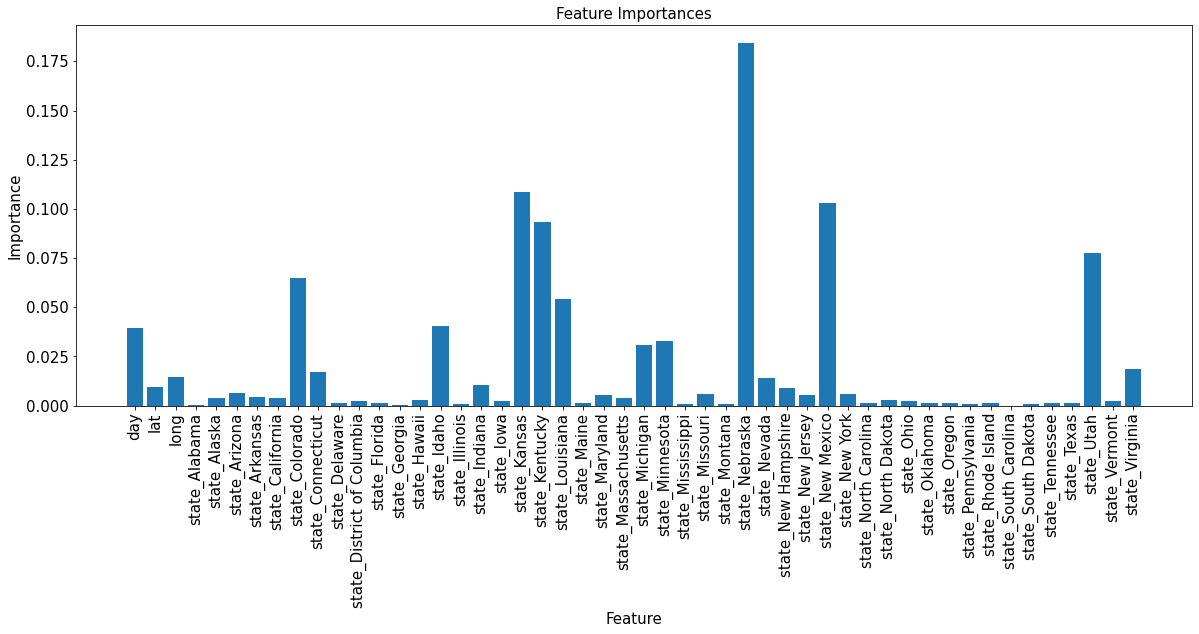

In [ ]:
best_pipeline = cvModel.bestModel
best_model = best_pipeline.stages[2]

importances = best_model.featureImportances
x = list(range(len(importances)))

plt.figure(figsize=(20, 7))
plt.bar(x, importances, orientation = 'vertical')
plt.xticks(x, columns_to_use, rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')
plt.show()

Interestingly, the number of days passed since the pandemic broke out in the US isn't the most influential feature. Some states turn out to be more influential in how our model predicts the number of cases. Nebraska, Kansas, and New Mexico are the biggest predictors. Comparing this to the cases by state graph we made in US Data Visualization, we find that the more inluential states generally have less diagnosed cases. While states with large numbers of cases like New York and New Jersey have very low importance.

To further understand model performance, we can also visualize predictions over the entire dataset.

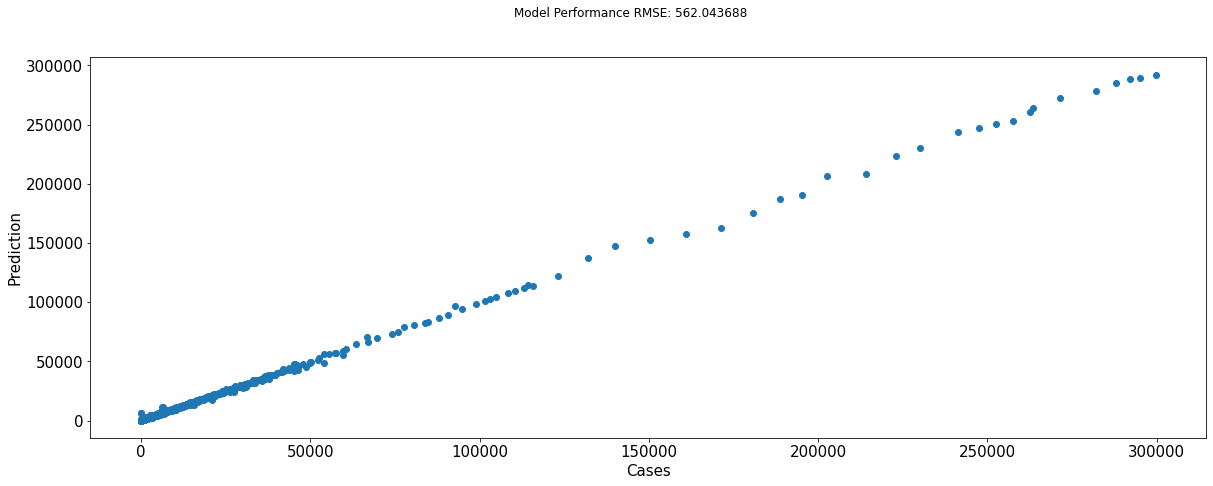

In [ ]:
import matplotlib.pyplot as plt

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions)

model_prediction = cvModel.transform(data_sdf).toPandas()

plt.figure(figsize=(20, 7))
plt.plot(model_prediction.label, model_prediction.prediction, 'o')
plt.xlabel('Cases')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

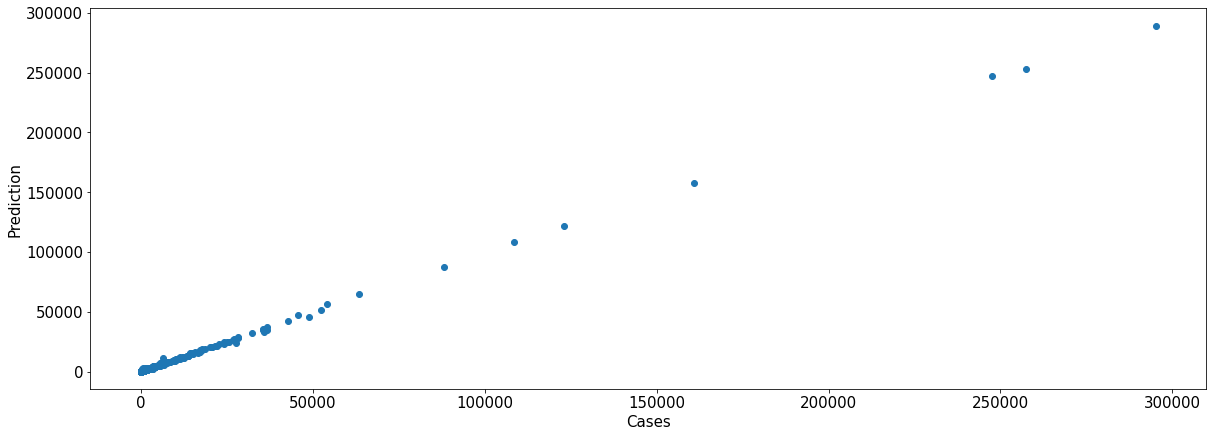

In [ ]:
test_prediction = predictions.toPandas()

plt.figure(figsize=(20, 7))
plt.plot(test_prediction.label, test_prediction.prediction, 'o')
plt.xlabel('Cases')
plt.ylabel('Prediction')
plt.show()

This also indicates that the performance of our model is good, since the predictions form a diagonal line.

In [ ]:
print('numTrees - ', best_model.getNumTrees)
print('maxDepth - ', best_model.getOrDefault('maxDepth'))


numTrees -  15
maxDepth -  20


Also, the hyperparameters we're using are 15 trees and a max depth of 20.

## Linear Regression
Since random forest regressions are not good at predicting time-series data, we will train a linear regression model.

### Model Setup
We will rescale the data by taking log of the cases column and store it as label_log, this will make the data appear more "linear".

In [ ]:
from pyspark.sql.functions import col, log
log_data_sdf = data_sdf.withColumn("label_log", log(col("label") + 1)).drop('label')
log_data_sdf.show(5)

+---+---+-----------+------------+-------------+------------+-------------+--------------+----------------+--------------+-----------------+--------------+--------------------------+-------------+-------------+------------+-----------+--------------+-------------+----------+------------+--------------+---------------+-----------+--------------+-------------------+--------------+---------------+-----------------+--------------+-------------+--------------+------------+-------------------+----------------+----------------+--------------+--------------------+------------------+----------+--------------+------------+------------------+------------------+--------------------+------------------+---------------+-----------+----------+-------------+--------------+----------------+-------------------+---------------+-------------+-----------------------------+-----------------------------+-----------------------+-------------------+----------------------+------------------+---------------------

For the linear regression model, we will also be using a vector assembler and PCA with 50 components to reduce data.

In [ ]:
from pyspark.ml.feature import VectorAssembler

all_columns = log_data_sdf.columns
drop_columns = ['label_log', '_c0']
columns_to_use = [i for i in all_columns if i not in drop_columns]

assembler = VectorAssembler(inputCols=columns_to_use, outputCol='features')

In [ ]:
from pyspark.ml.feature import PCA
pca = PCA(k=50, inputCol='features', outputCol='pca_features')

In [ ]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol='pca_features', labelCol='label_log')

In [ ]:
from pyspark.ml import Pipeline

pipe_lr = Pipeline(stages = [assembler, pca, lr])

The hyperparameters we're tuning for the linear regression model are the regularity parameter, elastic net param, and fit intercept.

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np

paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1]) \
    .addGrid(lr.elasticNetParam, [0, 0.25, 1]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .build()

In [ ]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

crossval_lr = CrossValidator(estimator=pipe_lr,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=RegressionEvaluator(labelCol='label_log'),
                          numFolds=3)

In [ ]:
lr_train_sdf, lr_test_sdf = log_data_sdf.randomSplit(weights=[0.8, 0.2])

In [ ]:
cvModel_lr = crossval_lr.fit(lr_train_sdf)

In [ ]:
predictions = cvModel_lr.transform(lr_test_sdf)

In [ ]:
predictions.show(15)

+---+---+-----------+-------------------+-------------+------------+-------------+--------------+----------------+--------------+-----------------+--------------+--------------------------+-------------+-------------+------------+-----------+--------------+-------------+----------+------------+--------------+---------------+-----------+--------------+-------------------+--------------+---------------+-----------------+--------------+-------------+--------------+------------+-------------------+----------------+----------------+--------------+--------------------+------------------+----------+--------------+------------+------------------+------------------+--------------------+------------------+---------------+-----------+----------+-------------+--------------+----------------+-------------------+---------------+-------------+-----------------------------+-----------------------------+-----------------------+-------------------+----------------------+------------------+--------------

In [ ]:
best_pipeline = cvModel_lr.bestModel
best_model = best_pipeline.stages[2]

In [ ]:
summary = best_model.summary
print(summary.r2)
print(summary.rootMeanSquaredError)

0.8955700018591496
0.9453651375316722


Our linear regression model has a RMSE of 0.94, so its performance is not as good as the random forest regression model. Since the data is not linear, this is an acceptable performance.

The hyperparameters we're using is the following:

In [ ]:
print('regParam - ', best_model._java_obj.getRegParam())
print('elasticNetParam - ', best_model._java_obj.getElasticNetParam())
print('elasticNetParam - ', best_model._java_obj.getMaxIter())

regParam -  0.01
elasticNetParam -  0.0
elasticNetParam -  100


Now we can also visualize the performance of the model by ploting prediction vs. actual value

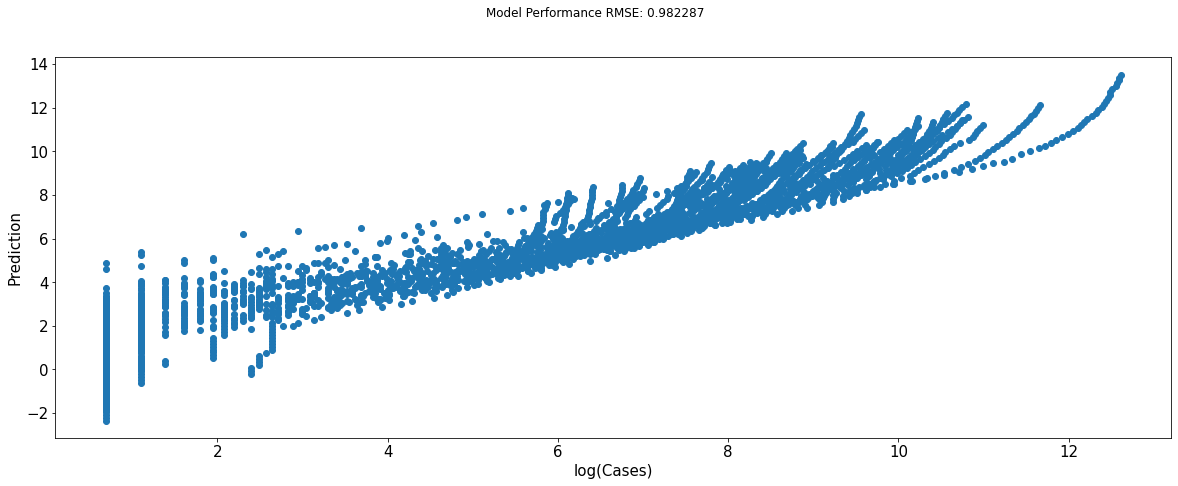

In [ ]:
import matplotlib.pyplot as plt

evaluator = RegressionEvaluator(labelCol="label_log", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions)

model_prediction = cvModel_lr.transform(log_data_sdf).toPandas()

plt.figure(figsize=(20, 7))
plt.plot(model_prediction.label_log, model_prediction.prediction, 'o')
plt.xlabel('log(Cases)')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

This plot is a lot more scattered than the one for random forest regression. Also, our model seems to be underpredicting, especially for small values, since some values are predicted to be negative when log(cases) is less than 2.

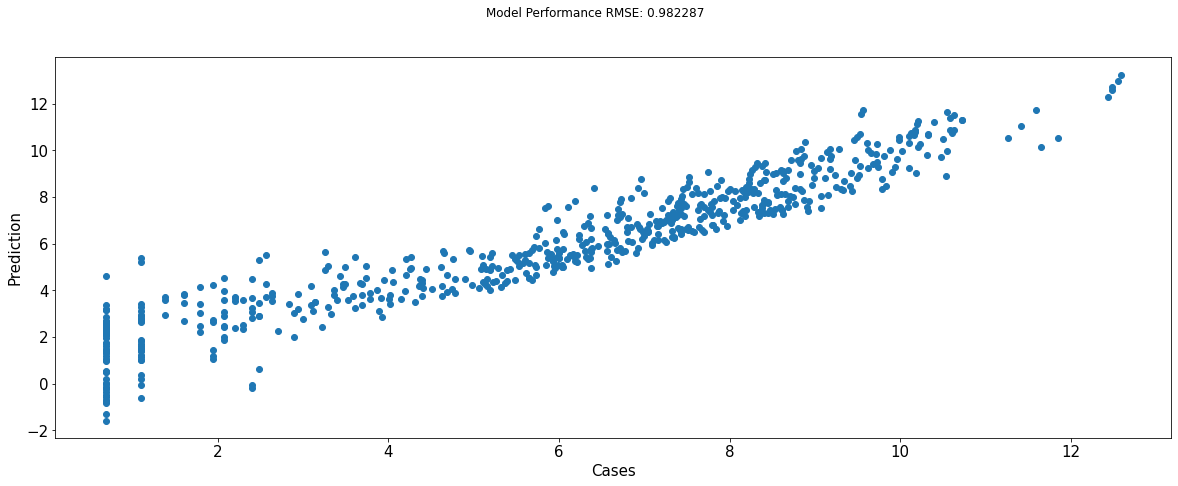

In [ ]:
test_prediction = predictions.toPandas()

plt.figure(figsize=(20, 7))
plt.plot(test_prediction.label_log, test_prediction.prediction, 'o')
plt.xlabel('Cases')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

The prediction on the test set also shows similar errors.

### Model Prediction
We will first read in the csv data containing only features of states for the first week of May.

In [ ]:
us_features = spark.read.csv('/content/drive/My Drive/COVID19/us_features.csv', inferSchema=True, header=True)

In [ ]:
may_prediction = cvModel_lr.transform(us_features)

We can transform the spark dataframe to Pandas, and append the predictions to the states

In [ ]:
prediction_df = may_prediction.select('prediction').toPandas()
prediction_df['actual_pred'] = np.exp(prediction_df['prediction'])

In [ ]:
us_states = pd.read_csv("/content/drive/My Drive/COVID19/us_states.csv", header=0)
may_df = pd.concat([us_states, prediction_df], axis = 1)

We can look at the prediction for the first week of May in New York.

In [ ]:
ny_may = ps.sqldf("SELECT * FROM may_df WHERE state = 'New York' AND day <= 107")
ny_may

,day,state,sub_region,region,lat,long,prediction,actual_pred
0,100,New York,mid_atlantic,northeast,41.162784,-73.757417,13.916802,1.106599e+06
1,101,New York,mid_atlantic,northeast,41.162784,-73.757417,14.052305,1.267180e+06
2,102,New York,mid_atlantic,northeast,41.162784,-73.757417,14.187807,1.451063e+06
3,103,New York,mid_atlantic,northeast,41.162784,-73.757417,14.323310,1.661630e+06
4,104,New York,mid_atlantic,northeast,42.701451,-78.221996,14.136784,1.378883e+06
5,105,New York,mid_atlantic,northeast,42.701451,-78.221996,14.272287,1.578976e+06
6,106,New York,mid_atlantic,northeast,42.701451,-78.221996,14.407789,1.808104e+06
7,107,New York,mid_atlantic,northeast,42.701451,-78.221996,14.543292,2.070482e+06


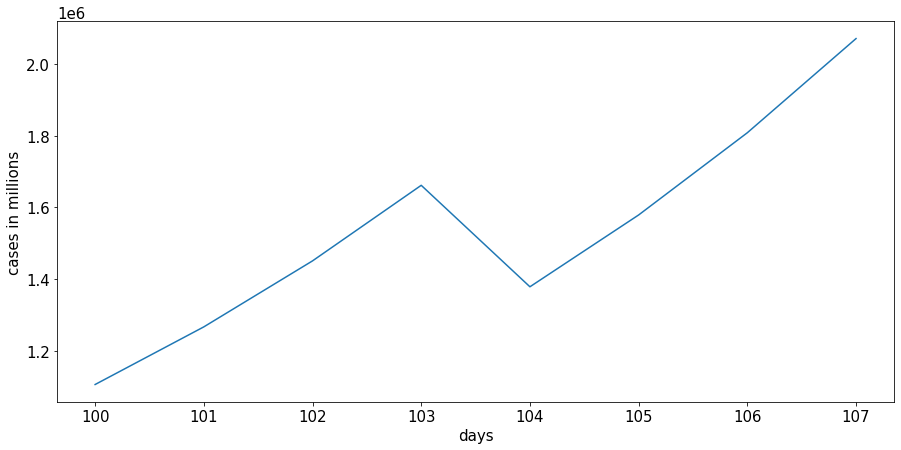

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(ny_may['day'], ny_may['actual_pred'])
plt.ylabel('cases in millions')
plt.xlabel('days')
plt.show()

Our model predicts that the number of confirmed cases in New York will surpass 2 million by Day 107, which is May 7th. The decrease from Day 103 to 104 is not possible and it is an error in the model prediction. 

From the two models we trained, we saw that time isn't neccessarily the most important indicator our model uses to predict data. Overall, random forest regression is more accurate on both the train set and test set. However, since it constitutes of ensembles of decision trees, it uses grouping to predict results. Thus on any data it has not seen before, it can only refer to how it grouped the training data and predict an average of data it was trained on. So the model is not reliable when the data is time-based. 

On the other hand, the linear regression model has a lower accuracy since the pandemic does not grow linearly. However, it'll have a better performance than random forest regression when it comes to predicting time-series data.